# **Inversión de datos SEV desplazados**

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import plot_1d_layer_model

mpl.rcParams.update({"font.size": 16})

# sphinx_gallery_thumbnail_number = 2

# Mediciones

In [2]:
# Mediciones sin desplazamiento estático

# Cargar el archivo
Datos_SEV = np.load("../FASE 1/SEV/DatosSEV.npy", allow_pickle=True).item()

# Extraer las variables
dobsSEV = Datos_SEV["dpredSEV"]
ab2  = Datos_SEV["ab2"]

In [3]:
dpred_desplazado = 0.2*dobsSEV

## Arreglo

In [4]:
# Arreglo tipo schlumberger

# Definir el espaciado de ab2 y número de sondeos
ab2= np.logspace(np.log10(2),np.log10(700),25) # Desde 1.5 metros a 200 metros

# Crear lista de las fuentes
source_list = []
for ii in range(0, len(ab2)):
    abb2 = ab2[ii]

    # Ubicación de los electrodos A y B
    A_location = np.r_[-abb2, 0.0, 0.0]
    B_location = np.r_[abb2, 0.0, 0.0]

    # Ubicación de los electrodos M y N
    M_location = np.r_[-abb2/3, 0.0, 0.0]
    N_location = np.r_[abb2/3, 0.0, 0.0]

    # Crear lista de receptores
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Definir las propiedades de las fuentes y receptores asociados
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Definir el arreglo
surveySEV = dc.Survey(source_list)

# **Inversión**

In [5]:
#Asignar incertidumbres y definir datos
uncertainties = 0.01 * np.abs(dpred_desplazado)
data_object = data.Data(surveySEV, dobs=dpred_desplazado, standard_deviation=uncertainties)

In [6]:
# Definir las celdas y extensión de la malla, debe ser 1.5 a 2 veces la DOI del método
layer_thicknesses =  np.logspace(0, 1.7, 15)

#1.7 y 15
# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

print(mesh)


  TensorMesh: 16 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     16          0.00        252.50      1.00     50.12    1.32




In [7]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(100 * np.ones((len(layer_thicknesses) + 1)))

# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

In [8]:
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=surveySEV,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [9]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh, alpha_s = 1e-8, alpha_x=1, reference_model=starting_model
)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=20, maxIterCG=30)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [10]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

In [11]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        


C:\Users\DANIELA\anaconda3\envs\simpeg0230v3\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.51e+07  5.75e+07  0.00e+00  5.75e+07    3.59e+07      0              
   1  7.55e+06  7.33e+06  3.35e-07  7.33e+06    4.97e+06      0              
   2  3.78e+06  9.05e+05  1.23e-06  9.05e+05    7.17e+05      0   Skip BFGS  
   3  1.89e+06  1.65e+05  2.36e-06  1.65e+05    1.16e+05      0   Skip BFGS  
   4  9.44e+05  8.04e+04  3.74e-03  8.39e+04    1.39e+04      0   Skip BFGS  
   5  4.72e+05  7.43e+04  7.79e-03  7.80e+04    8.18e+03      0   Skip BFGS  
   6  2.36e+05  6.59e+04  1.96e-02  7.06e+04    1.10e+04      0              
   7  1.18e+05  4.71e+04  6.24e-02  5.44e+04    1.51e+04      0              
   8  5.90e+04  1.62e+04  1.81e-01  2.68e+04    1.53e+04      0              
   9  2.95e+04  3.92e+03

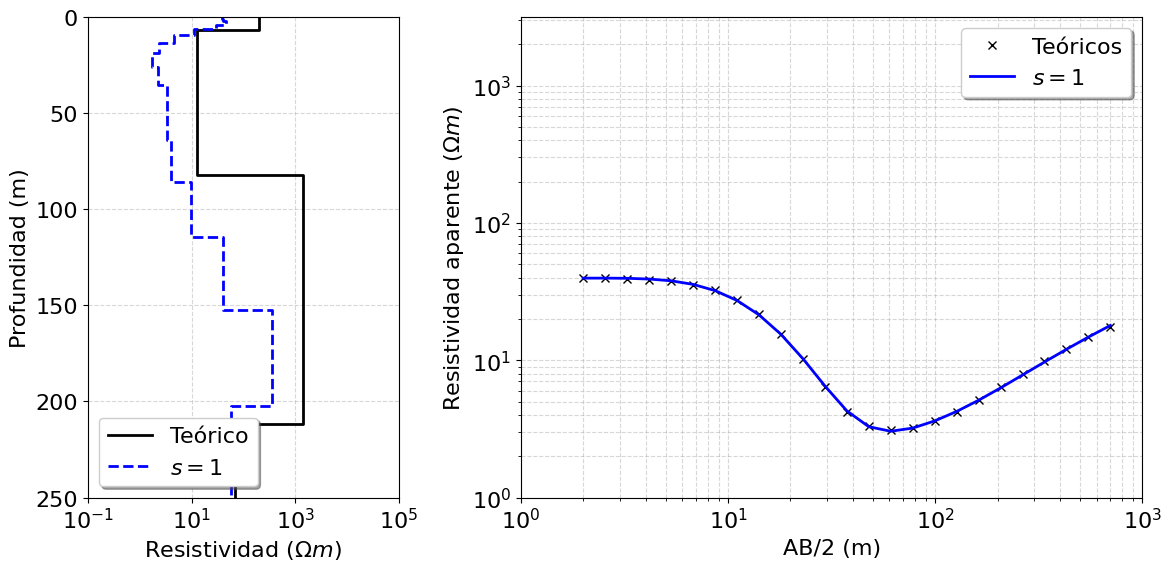

In [12]:
from matplotlib import gridspec
# Definir espesores de las capas
true_layers = np.r_[7, 75, 130]

# Definir resistividades de las capas
true_model = np.r_[200, 13, 1400, 70]

# Crear la figura y los subgráficos
fig = plt.figure(figsize=(12, 6))  # Tamaño de la figura
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # 1 fila, 2 columnas (izquierda más estrecha)

# Subgráfico 1: Modelo de resistividades (izquierda)
ax1 = fig.add_subplot(gs[0])
plot_1d_layer_model(true_layers, true_model, ax=ax1, color="black", lw=2, label="Teórico")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model,
    ax=ax1,
    color="blue",
    linestyle='--',
    lw=2,
    label="$\mathit{s}=1$"
)
#plot_1d_layer_model(
#    layer_thicknesses,
#    m3,
#    ax=ax1,
#    color="red",
#    linestyle='--',
#    lw=2,
#    label="$\mathit{s}=5$"
#)

ax1.set_xlim([10**-1, 10**5])
ax1.set_ylim([250, 0])
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.set_ylabel(r"Profundidad (m)")
ax1.grid(True, which="both", linestyle='--', alpha=0.5)
ax1.legend(loc='lower left', frameon=True, shadow=True, fancybox=True)

# Subgráfico 2: Mediciones de resistividad aparente (derecha)
ax2 = fig.add_subplot(gs[1])
ax2.loglog(ab2, dpred_desplazado, 'x', color="k", lw=2, label="Teóricos")  # Datos observados
ax2.loglog(ab2, inv_prob.dpred, color="blue", lw=2, label="$\mathit{s}=1$")  # Datos predichos
#ax2.loglog(ab2, dpred025, "red", lw=2, label="$\mathit{s}=0.2$")  # Datos predichos con otro parámetro
ax2.set_xlabel("AB/2 (m)")
ax2.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax2.set_ylim([10**0, 10**3.5])
ax2.set_xlim([10**0, 10**3])
ax2.grid(True, which="both", linestyle='--', alpha=0.5)
ax2.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Guardar la figura
filename = "Modelo_y_Mediciones_SEV.png"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')

plt.show()

Calcular el mse exacto

In [13]:
modelo_real = np.array([ 200.15330634,  200.13904746,  196.03503419,  225.14414923,
         34.06350559,   11.318957  ,    9.56881102,   24.87236047,
          6.61309662,   14.84827241,   14.78063448,   34.70787967,
         54.16703744, 1175.49391446, 2097.55130125,  129.06521952])

In [14]:
modelo_pred= model_map * recovered_model
modelo_pred

array([ 39.3965677 ,  40.1527529 ,  46.61428663,  29.63257079,
        11.19251907,   4.58784413,   2.38490098,   1.72979279,
         2.27117321,   3.39204195,   3.31714478,   3.95442078,
         9.78937865,  40.85077722, 363.29185924,  57.48685776])

In [15]:
# Resistividades 

mse1 = np.mean((modelo_real - modelo_pred) ** 2)
# Calcular el RMS
rms1 = np.sqrt(mse1)

print(f"MSE: {mse1}")
print(f"RMS: {rms1}")

MSE: 276033.5150856744
RMS: 525.3889179319206


Calcular el mse logarítmico

In [16]:
modelo_reallog = np.log10(modelo_real)
modelo_reallog

modelo_predlog = np.log10(modelo_pred)
modelo_predlog

array([1.59545839, 1.60371533, 1.66851904, 1.47176933, 1.04892784,
       0.66160865, 0.37747035, 0.23799408, 0.35625026, 0.53046121,
       0.52076443, 0.59708288, 0.99075513, 1.61120032, 2.56025567,
       1.75956857])

In [17]:
# Resistividades 

mse2 = np.mean((modelo_reallog - modelo_predlog) ** 2)
# Calcular el RMS
rms2 = np.sqrt(mse2)

print(f"MSE: {mse2}")
print(f"RMS: {rms2}")

MSE: 0.5976961192787478
RMS: 0.7731080902944606
